In [1]:
import random

from finrl.meta.env_portfolio_allocation import env_portfolio
import pandas as pd
import numpy as np
import gym
from typing import Callable, Tuple
from collections import defaultdict
from tqdm import trange


In [2]:
def generate_episode(env: gym.Env, policy: Callable, es: bool = False):
    """A function to generate one episode and collect the sequence of (s, a, r) tuples

    This function will be useful for implementing the MC methods

    Args:
        env (gym.Env): a Gym API compatible environment
        policy (Callable): A function that represents the policy.
        es (bool): Whether to use exploring starts or not
    """
    episode = []
    state = env.reset()
    while True:
        if es and len(episode) == 0:
            action = env.action_space.sample()
        else:
            action = policy(state)

        next_state, reward, done, _ = env.step(action)
        episode.append((state, action, reward))
        if done:
            break
        state = next_state

    return episode


In [3]:
############STUFF GRABBED FROM FINRL TUTORIAL
import matplotlib
import matplotlib.pyplot as plt

matplotlib.use('Agg')
%matplotlib inline
import datetime

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline, convert_daily_return_to_pyfolio_ts
from finrl.meta.data_processor import DataProcessor
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
import sys

## 2.4. Create Folders
import os

if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

print(config_tickers.DOW_30_TICKER)
#dp = YahooFinanceProcessor()
#df = dp.download_data

df = YahooDownloader(start_date='2008-01-01',
                     end_date='2021-10-31',
                     ticker_list=config_tickers.DOW_30_TICKER).fetch_data()

df.head()
df.shape


C:\Users\wacho\Programming\RL_Finance\venv\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

(101615, 8)

In [4]:
fe = FeatureEngineer(
    use_technical_indicator=True,
    use_turbulence=False,
    user_defined_feature=False)

df = fe.preprocess_data(df)
df.shape
df.head()

Successfully added technical indicators


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2008-01-02,7.116786,7.152143,6.876786,5.898640,1079178800,AAPL,2,0.0,5.903856,5.896149,100.0,-66.666667,100.0,5.898640,5.898640
3483,2008-01-02,46.599998,47.040001,46.259998,33.761421,7934400,AMGN,2,0.0,5.903856,5.896149,100.0,-66.666667,100.0,33.761421,33.761421
6966,2008-01-02,52.090000,52.320000,50.790001,39.588001,8053700,AXP,2,0.0,5.903856,5.896149,100.0,-66.666667,100.0,39.588001,39.588001
10449,2008-01-02,87.570000,87.839996,86.000000,63.481636,4303000,BA,2,0.0,5.903856,5.896149,100.0,-66.666667,100.0,63.481636,63.481636
13932,2008-01-02,72.559998,72.669998,70.050003,45.605461,6337800,CAT,2,0.0,5.903856,5.896149,100.0,-66.666667,100.0,45.605461,45.605461


In [5]:
df.tail()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
83591,2021-10-29,162.130005,162.440002,160.660004,153.936371,1314100,TRV,4,1.424915,156.635668,144.752566,55.691949,130.838092,19.622993,149.630909,150.155364
87074,2021-10-29,454.410004,461.390015,453.059998,447.971069,2497800,UNH,4,12.812441,459.914498,366.732087,67.009705,145.348177,52.064871,406.440822,405.562352
90557,2021-10-29,52.500000,53.049999,52.410000,46.802307,17763200,VZ,4,-0.170568,48.086327,45.189775,46.685012,-39.966415,12.569826,46.875141,47.474614
94040,2021-10-29,46.860001,47.279999,46.770000,41.523598,4999000,WBA,4,-0.169816,44.202651,40.524219,45.913432,-97.395095,0.268701,42.391106,42.889371
97523,2021-10-29,147.910004,150.100006,147.559998,144.852386,7340900,WMT,4,1.795638,147.887248,129.205261,59.710636,130.750128,35.423702,138.057019,140.642311


In [6]:

## Add covariance matrix as states
# add covariance matrix as states
df = df.sort_values(['date', 'tic'], ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback = 252
for i in range(lookback, len(df.index.unique())):
    data_lookback = df.loc[i - lookback:i, :]
    price_lookback = data_lookback.pivot_table(index='date', columns='tic', values='close')
    return_lookback = price_lookback.pct_change().dropna()
    return_list.append(return_lookback)

    covs = return_lookback.cov().values
    cov_list.append(covs)

df_cov = pd.DataFrame({'date': df.date.unique()[lookback:], 'cov_list': cov_list, 'return_list': return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date', 'tic']).reset_index(drop=True)

df.shape
df.head()


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2008-12-31,3.070357,3.133571,3.047857,2.583909,607541200,AAPL,2,-0.082603,3.093652,2.454291,42.254767,-80.462576,16.129793,2.749560,2.861671,"[[0.0013489702062126118, 0.0004284140120351745...",tic AAPL AMGN AXP ...
1,2008-12-31,57.110001,58.220001,57.060001,41.839512,6287200,AMGN,2,0.156755,42.707032,40.853195,51.060596,51.523176,10.432018,41.058034,40.603776,"[[0.0013489702062126118, 0.0004284140120351745...",tic AAPL AMGN AXP ...
2,2008-12-31,17.969999,18.750000,17.910000,14.580747,9625600,AXP,2,-0.935583,18.646871,12.660473,42.554836,-75.437707,25.776759,15.744064,17.616374,"[[0.0013489702062126118, 0.0004284140120351745...",tic AAPL AMGN AXP ...
3,2008-12-31,41.590000,43.049999,41.500000,32.005890,5443100,BA,2,-0.279800,32.174382,28.867834,47.440240,156.994839,5.366299,30.327213,32.389914,"[[0.0013489702062126118, 0.0004284140120351745...",tic AAPL AMGN AXP ...
4,2008-12-31,43.700001,45.099998,43.700001,29.608660,6277400,CAT,2,0.655612,30.348092,25.455646,51.205316,98.374172,26.331746,26.689550,26.423592,"[[0.0013489702062126118, 0.0004284140120351745...",tic AAPL AMGN AXP ...


In [7]:
## Training data split: 2009-01-01 to 2020-07-01
train = data_split(df, '2009-01-01', '2020-07-01')
#trade = data_split(df, '2020-01-01', config.END_DATE)
train.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2009-01-02,3.067143,3.251429,3.041429,2.747390,746015200,AAPL,4,-0.070153,3.080130,2.452222,45.440192,-32.212901,2.140064,2.750408,2.862473,"[[0.0013661519386651696, 0.0004339396359097349...",tic AAPL AMGN AXP ...
0,2009-01-02,58.590000,59.080002,57.750000,42.737896,6547900,AMGN,4,0.232162,42.852626,40.817724,52.756862,92.827991,0.814217,41.122031,40.691923,"[[0.0013661519386651696, 0.0004339396359097349...",tic AAPL AMGN AXP ...
0,2009-01-02,18.570000,19.520000,18.400000,15.193844,10955700,AXP,4,-0.832050,18.463255,12.644437,43.957540,-42.853122,16.335101,15.742754,17.499518,"[[0.0013661519386651696, 0.0004339396359097349...",tic AAPL AMGN AXP ...
0,2009-01-02,42.799999,45.560001,42.779999,33.941101,7010200,BA,4,-0.002008,32.948628,28.452127,50.822045,272.813005,20.494464,30.469479,32.344130,"[[0.0013661519386651696, 0.0004339396359097349...",tic AAPL AMGN AXP ...
0,2009-01-02,44.910000,46.980000,44.709999,31.093407,7117200,CAT,4,0.833184,30.850192,25.434762,53.661265,129.524728,34.637448,26.926402,26.424173,"[[0.0013661519386651696, 0.0004339396359097349...",tic AAPL AMGN AXP ...


In [8]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym_random = StockPortfolioEnv(df = train, **env_kwargs)
e_train_gym_single_stock_sarsa = StockPortfolioEnv(df = train, **env_kwargs)


Stock Dimension: 28, State Space: 28


In [87]:
import random
def random_agent(env: StockPortfolioEnv):
    env.reset()
    terminal = False
    while not terminal:
        action = [0] * len(env.action_space.sample())
        action[random.randint(0,  len(env.action_space.sample()) - 1)] = 1
        state, reward, terminal, _, _ = env.step(action)
    return env

In [88]:
env_rand_post_training = random_agent(e_train_gym_random)

begin_total_asset:1000000
end_total_asset:6170194.176749557
Sharpe:  0.959957919751413


In [157]:
from agents.single_stock_tabular import sarsa_single_stock

In [166]:

env_sarsa_post_training, episodes = sarsa_single_stock(e_train_gym_single_stock_sarsa, num_episodes=5, gamma=0.99, epsilon=0.1, step_size=0.5, stock=0)

Episode:  20%|██        | 1/5 [00:10<00:42, 10.66s/it]

begin_total_asset:1000000
end_total_asset:6203102.413276671
Sharpe:  0.9618631635961972


Episode:  40%|████      | 2/5 [00:20<00:30, 10.19s/it]

begin_total_asset:1000000
end_total_asset:6329813.8078680895
Sharpe:  0.9716504956352059


Episode:  60%|██████    | 3/5 [00:30<00:20, 10.06s/it]

begin_total_asset:1000000
end_total_asset:6524831.188117347
Sharpe:  0.9870304344389413


Episode:  80%|████████  | 4/5 [00:40<00:09,  9.99s/it]

begin_total_asset:1000000
end_total_asset:6317552.020430323
Sharpe:  0.9711165095866864


begin_total_asset:1000000
end_total_asset:6419944.4365403745
Sharpe:  0.9786449978478284


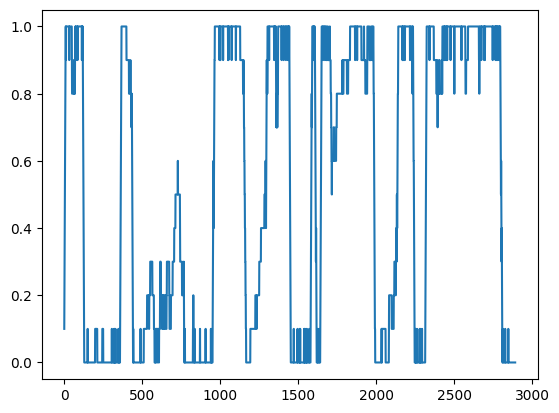

In [167]:
percent = [e[3] for e in episodes[0]]
plt.plot(list(range(len(percent))), percent)



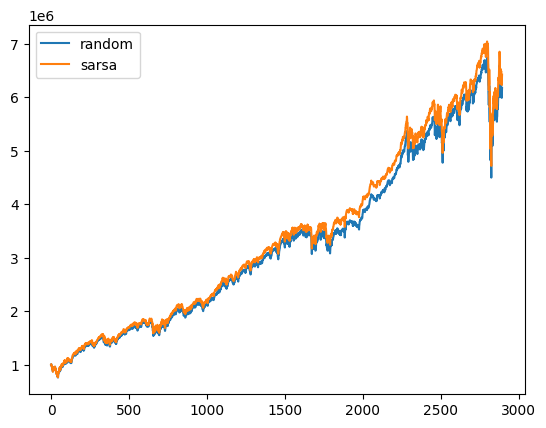

In [168]:
plt.plot(list(range(len(env_rand_post_training.portfolio_return_memory

))), env_rand_post_training.asset_memory, label="random"
)
plt.plot(list(range(len(env_sarsa_post_training.portfolio_return_memory

))), env_sarsa_post_training.asset_memory, label="sarsa"

)
plt.legend()
plt.show()

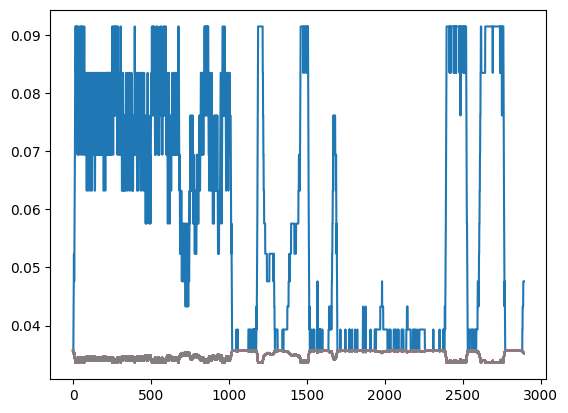

In [169]:
plt.plot(env_sarsa_post_training.actions_memory)